C:\Users\joytr\AppData\Local\Temp\ipykernel_23528\419899749.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xi_hat[i] = sum(final_array) / len(final_array)


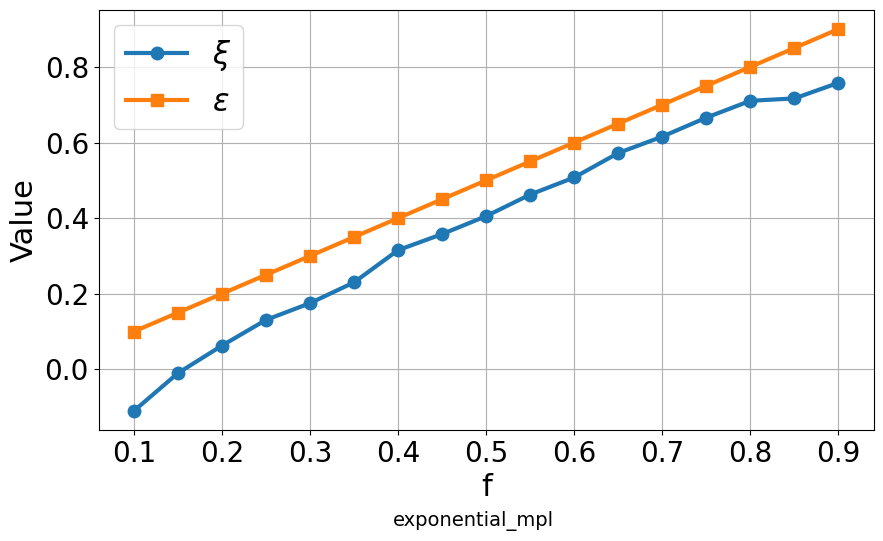

In [1]:
import numpy as np
from scipy.stats import laplace, norm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.optimize import root_scalar
from scipy.stats import gaussian_kde
from statsmodels.distributions.empirical_distribution import ECDF

# Fill adjacent data sets
B = 10  # Dimension of input parameters
x_mat = np.zeros(B)
x_prime_mat = np.zeros(B)
for b in range(1, B + 1):
    x_mat[b - 1] = 1
    x_prime_mat[b - 1] = 1 + b / B


# Define functions for calculating privacy parameters
def hyp_distance_max(scal_par):
    m_1 = 2
    m_2 = 1
    out = scal_par * (max(m_1, m_2) - min(m_1, m_2)) + np.log(2 - np.exp(
        -scal_par * max(m_1, m_2))) - np.log(2 -
                                             np.exp(-scal_par * min(m_1, m_2)))
    return out


def inverse(f, lower=-100, upper=100):

    def wrapper(y):
        return root_scalar(lambda x: f(x) - y, bracket=[lower, upper]).root

    return wrapper


hyp_inverse = inverse(hyp_distance_max, 0, 10)


# Implementation of the exponential mechanism
def exp_mech(mu, scal_par, number):
    covec = np.array([])
    while len(covec) <= number:
        laplace_vec = laplace.rvs(size=number, loc=mu, scale=scal_par)
        laplace_vec = laplace_vec[laplace_vec >= 0]
        covec = np.concatenate((covec, laplace_vec))
    return covec[:number]


# MPL function
def MPL(epsilon):
    eps_vec = np.zeros(B)
    t_vec = np.zeros(B)
    h_est = 0

    for b in range(0, B - 1):
        X = exp_mech(x_mat[b], 1 / epsilon, n)
        Y = exp_mech(x_prime_mat[b], 1 / epsilon, n)
        kdX = gaussian_kde(X)
        kdY = gaussian_kde(Y)
        h_est += (kdX.factor + kdY.factor) / 2
        log_X = np.log(kdX.evaluate(C_discr))
        log_X[log_X < np.log(delta)] = 0
        log_Y = np.log(kdY.evaluate(C_discr))
        log_Y[log_Y < np.log(delta)] = 0
        log_difference = np.abs(log_X - log_Y)
        hat_eps = max(log_difference)
        hat_t = np.argmax(log_difference)
        eps_vec[b] = hat_eps
        t_vec[b] = hat_t
    h_est = h_est / B
    b_star = np.argmax(eps_vec)
    t_max = t_vec[b_star] / (len(C_discr) - 1) * glob + C[0]

    h_max = h_est**(1 + tune)

    X = exp_mech(x_mat[b_star], 1 / epsilon, N)
    Y = exp_mech(x_prime_mat[b_star], 1 / epsilon, N)
    kdX_star = gaussian_kde(X, bw_method=h_max)
    kdY_star = gaussian_kde(Y, bw_method=h_max)
    hat_ell_star = np.abs(
        np.log(kdX_star.evaluate(t_max)) - np.log(kdY_star.evaluate(t_max)))
    c_N = np.sqrt(N * kdX_star.factor)
    hat_sigma = np.sqrt(
        1 / (2 * np.sqrt(np.pi)) *
        (1 / kdX_star.evaluate(t_max) + 1 / kdY_star.evaluate(t_max)))
    LB = norm.ppf(alpha) * hat_sigma / c_N + hat_ell_star

    return LB


# Inputs
C = np.array([0, 2])
glob = C[1] - C[0]
C_discr = np.arange(21) / 20 * glob + C[0]
n = 20000
N = 50000
delta = 0.001
tune = 0.15
alpha = 0.05



reps = 500

f_values = np.arange(0.1, 0.95, 0.05)
epslion_star = np.zeros_like(f_values)
xi_hat = np.zeros_like(f_values)
epsilon = np.zeros_like(f_values)

for i, f in enumerate(f_values):
    epslion_star[i] = f
    epsilon[i] = hyp_inverse(f)
    A = Parallel(n_jobs=7)(delayed(MPL)(epsilon[i]) for _ in range(reps))
    final_array = np.array(A)
    xi_hat[i] = sum(final_array) / len(final_array)

plt.figure(figsize=(10, 6))
plt.subplots_adjust(bottom=0.18)

# print the first line
plt.plot(f_values, xi_hat, marker='o', markersize=9,linewidth=3,label=r'$\xi$')

# print the second line
plt.plot(f_values, epslion_star, marker='s',markersize=9, linewidth=3,label=r'$\epsilon$')




plt.xlabel('f', fontsize=22)
plt.ylabel('Value', fontsize=22)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)  
plt.legend(fontsize=22)
plt.grid(True)

# gcf: Get Current Figure
fig=plt.gcf()
fig.text(0.5, 0.02, 'exponential_mpl', ha='center', fontsize=14)
fig.savefig('expo.svg',format='svg')